# Reservoir computing clásico y cuántico en EEG simulados.

## Carga de librerías.

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt
from sklearn.cluster import KMeans
import pandas as pd
import random

## Carga de los datos.

In [2]:
# Carga de datos.
eeg_synthetic = np.load("./data/data/synthetic_data_auto.npy")

(40, 2000, 10)


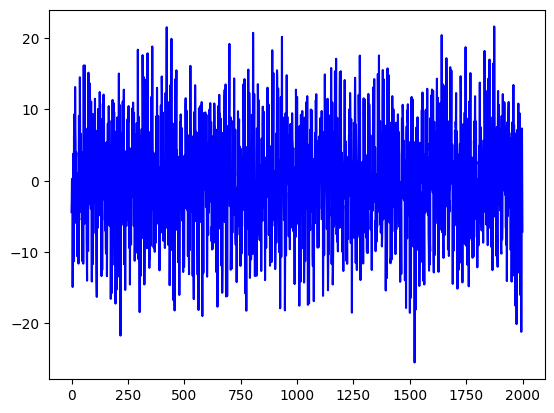

In [3]:
# Cogemos el EEG sintético de un joven.
print(eeg_synthetic.shape)
sujeto_synt = eeg_synthetic[0,:,:]

plt.plot(range(sujeto_synt.shape[0]), sujeto_synt[:,0], color = 'blue')
plt.show()

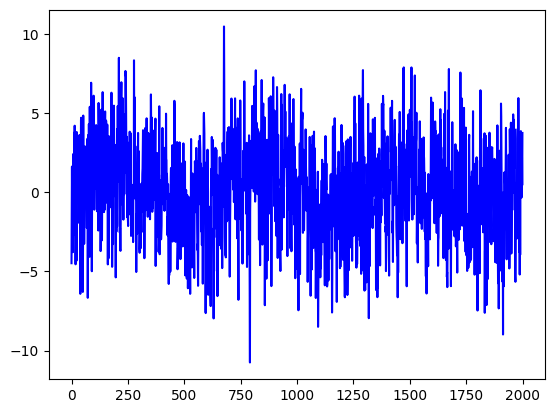

In [4]:
# Cogemos el EEG sintético de un adulto.
sujeto_synt_adult = eeg_synthetic[21,:,:]

plt.plot(range(sujeto_synt_adult.shape[0]), sujeto_synt_adult[:,0], color = 'blue')
plt.show()

## RC clásico Sujeto Joven.

Normalización espectral sobre la matriz de pesos recurrentes del reservorio.

Es escalar la matriz res2res para que su radio espectral (el mayor valor absoluto de sus autovalores) sea igual a un valor específico, normalmente < 1.

Estabilidad:
Si el radio espectral es muy alto, la dinámica del reservorio puede volverse explosiva (valores grandes).
Si es muy bajo, se vuelve inactivo o insensible a nuevas entradas.

Memoria temporal controlada:
Un valor cercano a 1 (~0.9) le da mejor capacidad de memoria a corto plazo, ideal para señales temporales.

Mejor rendimiento y reproducibilidad en tareas de regresión o clasificación temporal.

In [5]:
# Implementación reservoir clásico con un sujeto joven.

# Parámetros
num_input_channels = 10     # Dimensionalidad de entrada (10 canales)
num_reservoir_neurons = 80   # Número de neuronas en el reservorio
num_readout_neurons = 1      # Número de neuronas de salida

num_training_samples = sujeto_synt.shape[0] # Número de muestras de entrenamiento

# Generar pesos de entrada al reservorio
input2res = np.random.randn(num_reservoir_neurons, num_input_channels)

# Generar pesos recurrentes del reservorio
res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)

# Normalizar las columnas de los pesos recurrentes
res2res = res2res / np.linalg.norm(res2res, axis=0)

# Normalización espectral
eigvals = np.linalg.eigvals(res2res)
spectral_radius = np.max(np.abs(eigvals))
desired_radius = 0.9

# Escalar la matriz recurrente
res2res = (res2res / spectral_radius) * desired_radius

# Sesgo del reservorio
input_bias = np.random.rand(num_reservoir_neurons, 1)

# Estados iniciales del reservorio
#reservoir_states = np.zeros((num_reservoir_neurons, num_training_samples + 1))
reservoir_states = np.random.randn(num_reservoir_neurons,num_training_samples + 1);

# Dinámicas del reservorio
for i in range(num_training_samples):
    reservoir_states[:, i + 1] = np.tanh(
        (0.05 * input2res @ sujeto_synt[i,:]) +
        (0.95 * res2res @ reservoir_states[:, i]) +
        input_bias.flatten()
    )

# Extracción de la envolvente superior usando Hilbert transform
RS_clasico_joven_synt = reservoir_states - np.mean(reservoir_states, axis = 1, keepdims=True)
print(RS_clasico_joven_synt.shape)
analytic_signal = hilbert(RS_clasico_joven_synt)
amplitude_envelope_clasico_joven_synt = np.abs(analytic_signal)

print(analytic_signal.shape)
print(RS_clasico_joven_synt.shape)
print(amplitude_envelope_clasico_joven_synt.shape)

(80, 2001)
(80, 2001)
(80, 2001)
(80, 2001)


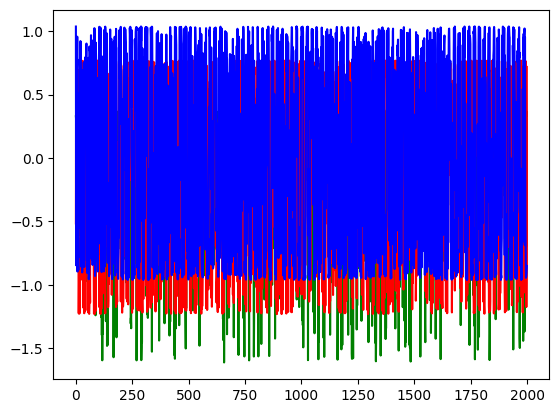

In [6]:
plt.plot(range(sujeto_synt.shape[0]), RS_clasico_joven_synt[0, 1:], color = 'green')
plt.plot(range(sujeto_synt.shape[0]), RS_clasico_joven_synt[1, 1:], color = 'red')
plt.plot(range(sujeto_synt.shape[0]), RS_clasico_joven_synt[2, 1:], color = 'blue')
plt.show()

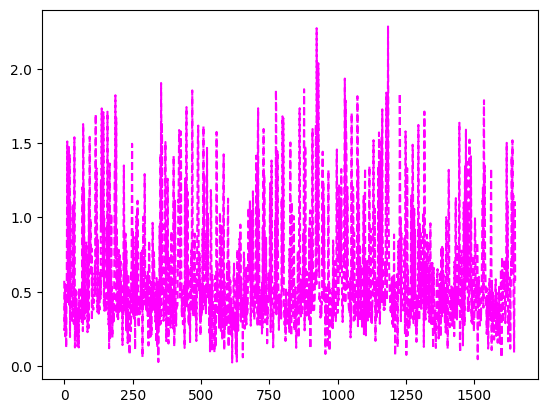

In [7]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(300, amplitude_envelope_clasico_joven_synt.shape[1])
input_sequence_clasico_joven_synt = amplitude_envelope_clasico_joven_synt[:, stable_start:-50]
plt.plot(input_sequence_clasico_joven_synt[0, 1:], linestyle="dashed", color = 'magenta')
plt.show()

In [10]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence_clasico_joven_synt.T)

# Resultados
idx_clasico_joven_synt = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx_clasico_joven_synt.shape)

Centroides de los clústeres:
[[0.55766546 0.84352252 1.02498143 0.96281204 1.00170378 0.59378287
  1.08998215 0.86074234 0.94303473 0.95252417 0.76900533 0.87765384
  0.92517794 0.82919576 1.1670138  0.97679521 0.65030941 0.7196817
  0.85680369 0.91064273 1.04694863 0.7762588  0.62240496 1.08479913
  0.7012873  0.82331655 0.89469691 0.88712098 0.79871041 0.72282365
  0.79244618 0.99899174 0.90101868 0.63977623 0.69717632 1.05550878
  0.99696152 0.51764181 0.80546499 0.64563413 1.1413948  0.88260711
  0.81580332 0.76599591 0.85696018 0.9245858  0.76678872 1.05018862
  0.9372212  0.90539988 0.84917988 0.94845893 0.74952505 0.95582558
  0.70742932 0.86267407 0.34169414 0.56236663 0.86528592 0.93132687
  0.66694333 0.86504444 0.90425896 1.12425343 1.00100958 1.09699929
  0.60555709 0.75434324 0.84124398 0.94780271 0.94742019 0.4573175
  0.60435177 0.63722734 0.53953571 1.03322973 0.84662364 0.64160704
  0.81915798 0.94758686]
 [0.62307803 1.0546718  1.02269962 1.05643207 0.94925307 0.56001

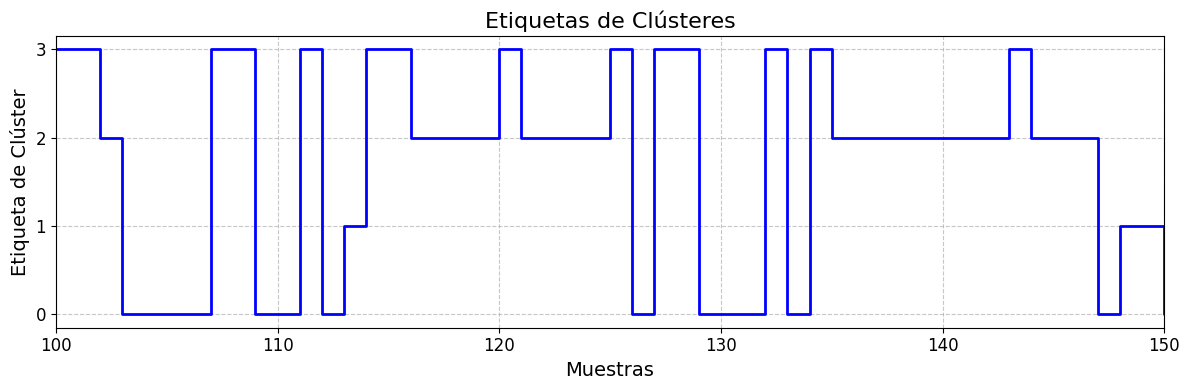

In [11]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_clasico_joven_synt.shape[1]), idx_clasico_joven_synt, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.xlim([100,150])
plt.tight_layout() 
plt.show()

In [8]:
from sklearn.mixture import GaussianMixture

def clustering_gmm(input_sequence, n_components=4):  
    """  
    Función para realizar agrupamiento usando GMM.  

    Args:  
    - input_sequence: Array de entrada procesado para el agrupamiento.  
    - num_clusters: Número de estados cerebrales. Default es 4.  

    Returns:  
    - labels: Etiquetas de los clústeres asignados a cada muestra de entrada. 
    """
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    cluster_labels = gmm.fit_predict(input_sequence.T)
    return cluster_labels

idx_clasico_joven_synt_gmm = clustering_gmm(input_sequence_clasico_joven_synt)

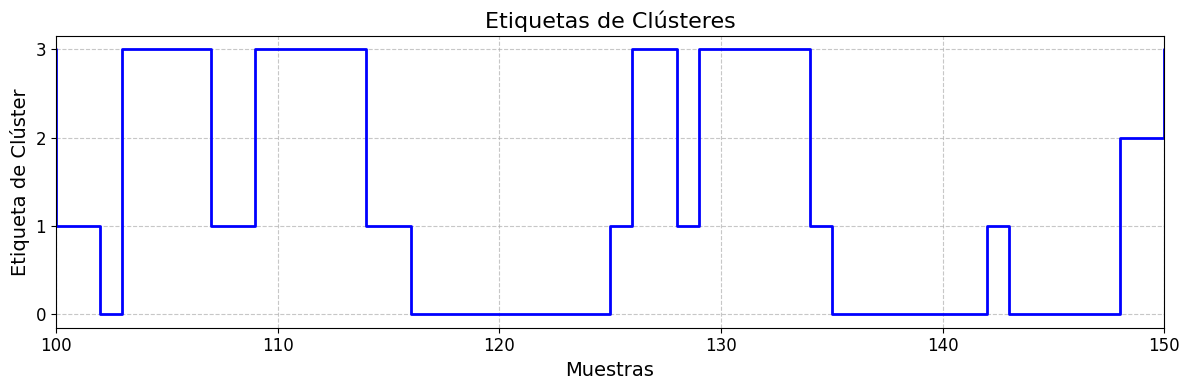

In [12]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_clasico_joven_synt.shape[1]), idx_clasico_joven_synt_gmm, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.xlim([100,150])
plt.tight_layout() 
plt.show()

## RC Cuántico Sujeto Joven.

In [13]:
# Definir parámetros principales
num_qubits = 5 # hacemos uso de 5 qubits
num_channels = 10  # Número de canales

# Dispositivo cuántico
dev = qml.device("default.qubit", wires=num_qubits)

def quantum_reservoir(reservoir_weights, connectivity):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""  
    for i in range(num_qubits):
        qml.RX(reservoir_weights[i, i], wires=i)

    if connectivity == 'ring':  
        for j in range(num_qubits - 1):  
            qml.CNOT(wires=[j, j+1])  
    
    elif connectivity == 'star':  
        central_qubit = 0
        for j in range(1, num_qubits):  
            qml.CNOT(wires=[central_qubit, j])  

    elif connectivity == 'random':  
        qubit_pairs = [(j, k) for j in range(num_qubits) for k in range(j + 1, num_qubits)]  
        random.shuffle(qubit_pairs)  
        for j, k in qubit_pairs[num_qubits // 2]:  
            qml.CNOT(wires=[j, k])  
    
    elif connectivity == 'full':  
        for j in range(num_qubits):  
            for k in range(j + 1, num_qubits):  
                qml.CNOT(wires=[j, k])  

@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN) con 5 qubits activos por canal."""
    for i in range(num_qubits):
        qml.RX(0.05 * weights_in[i,:] @ input_data[:] + 0.95 * weights_rc[i,i] * prev_output[i], wires=i)
    
    quantum_reservoir(reservoir_weights, connectivity='full')
    
    return qml.probs(wires=range(num_qubits)) 

In [14]:
# Inicialización de pesos

weights_in = np.random.uniform(-np.pi, np.pi, (num_qubits, num_channels))
weights_rc = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))
reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))

# Normalización espectral de weights_rc
eigvals = np.linalg.eigvals(weights_rc)
spectral_radius = np.max(np.abs(eigvals))
desired_radius = 0.9
weights_rc = (weights_rc / spectral_radius) * desired_radius

# Señal con múltiples canales
input_series = sujeto_synt
time_steps = input_series.shape[0]

shape_qubits = 32

outputs = np.zeros((time_steps, shape_qubits))  # Salida esperada
prev_output = np.zeros((shape_qubits))  # Estado anterior de salida

# Loop de propagación en el tiempo
for t in range(time_steps):
    q_probs = quantum_echo_state_network(input_series[t,:], prev_output[:], weights_in, weights_rc, reservoir_weights)
    final_output = np.tanh(q_probs)
    outputs[t,:] = final_output
    prev_output[:] = final_output  # Actualizar el estado anterior
    print(f"Step {t}: {outputs[t,:]}")

Step 0: [7.66946316e-02 4.72955197e-03 1.85080211e-03 3.00624948e-02
 1.28083300e-04 2.08107295e-03 5.31797874e-03 3.27306971e-04
 5.05457138e-05 8.21258082e-04 2.09865899e-03 1.29165667e-04
 3.03163826e-02 1.86644226e-03 7.30385641e-04 1.18666283e-02
 2.48114907e-04 4.03130757e-03 1.03013865e-02 6.34038408e-04
 1.47770450e-01 9.16160247e-03 3.58524613e-03 5.81869245e-02
 3.60285082e-01 2.32120638e-02 9.08483545e-03 1.46550063e-01
 6.28725372e-04 1.02150703e-02 2.60988029e-02 1.60665796e-03]
Step 1: [1.84389315e-04 1.72165114e-02 1.22864311e-02 1.31581638e-04
 1.44560794e-02 1.54820498e-04 2.16954629e-04 2.02563799e-02
 2.21247711e-02 2.36972167e-04 3.32076236e-04 3.09992337e-02
 2.82230944e-04 2.63485319e-02 1.88046516e-02 2.01402181e-04
 1.12113097e-01 1.20568376e-03 1.68956021e-03 1.56474566e-01
 1.43595428e-03 1.33291127e-01 9.53959905e-02 1.02470840e-03
 9.38149172e-04 8.73806626e-02 6.24336370e-02 6.69470582e-04
 7.34234512e-02 7.87706893e-04 1.10383720e-03 1.02712486e-01]
Step 2

In [15]:
outputs = outputs.T
outputs.shape

(32, 2000)

In [16]:
RS_cuantico_eeg_simulado_joven = outputs - np.mean(outputs,axis=1, keepdims=True)
print(RS_cuantico_eeg_simulado_joven.shape)

(32, 2000)


In [17]:
# Aplicamos la transformada de Hilbert a los estados del reservoir.
analytic_signal = hilbert(RS_cuantico_eeg_simulado_joven)
amplitude_envelope_eeg_simulado_joven= np.abs(analytic_signal)

print(analytic_signal.shape)
print(amplitude_envelope_eeg_simulado_joven.shape)

(32, 2000)
(32, 2000)


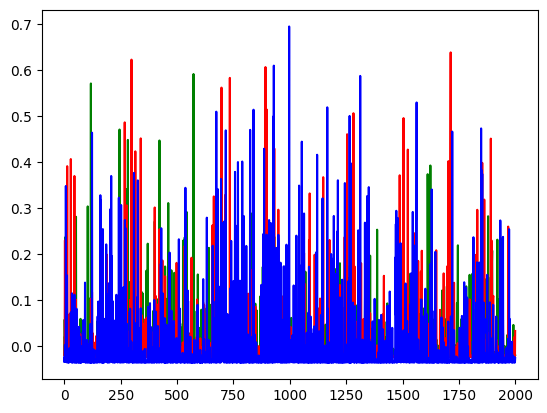

In [18]:
plt.plot(range(sujeto_synt.shape[0]), RS_cuantico_eeg_simulado_joven [0,:], color = 'green')
plt.plot(range(sujeto_synt.shape[0]), RS_cuantico_eeg_simulado_joven [1,:], color = 'red')
plt.plot(range(sujeto_synt.shape[0]), RS_cuantico_eeg_simulado_joven [2,:], color = 'blue')
plt.show()

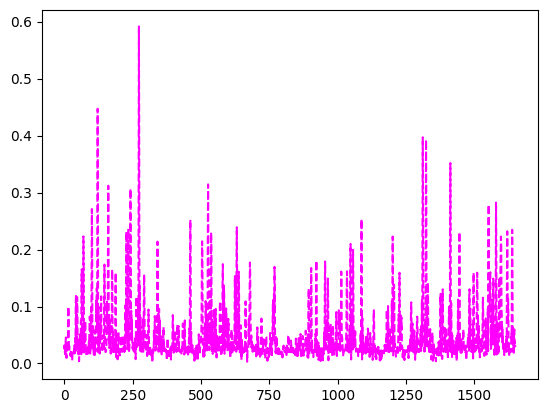

In [19]:
# Eliminamos los primeros puntos para estabilizar el reservorio
stable_start = min(300, amplitude_envelope_eeg_simulado_joven.shape[1])
input_sequence_cuant_eeg_simulado_joven = amplitude_envelope_eeg_simulado_joven[:,stable_start:-50]
plt.plot(input_sequence_cuant_eeg_simulado_joven[0,:], linestyle="dashed", color = 'magenta')
plt.show()

In [20]:
# Agrupamiento (clustering)
num_clusters = 4  # Número de clústeres
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(input_sequence_cuant_eeg_simulado_joven.T)

# Resultados
idx_cuantico_simulado_joven = kmeans.labels_  # Etiquetas de los clústeres
C = kmeans.cluster_centers_  # Centroides de los clústeres

print("Centroides de los clústeres:")
print(C)
print(idx_cuantico_simulado_joven.shape)

Centroides de los clústeres:
[[0.03494193 0.04507773 0.06414412 0.06116805 0.05927322 0.07451445
  0.04469717 0.04511406 0.07160628 0.07119275 0.04953864 0.04597877
  0.04422782 0.04651609 0.05516635 0.06473859 0.09634594 0.16699099
  0.09436178 0.07058645 0.06720929 0.0575535  0.07195558 0.10339732
  0.06044525 0.04844995 0.06571383 0.09293571 0.09037841 0.17497469
  0.08020292 0.06027334]
 [0.03610764 0.05073881 0.09628606 0.07388618 0.05508194 0.0548248
  0.04485681 0.04078493 0.05870891 0.06369656 0.04510689 0.03746918
  0.04705551 0.04558564 0.08098117 0.07623244 0.06096982 0.068983
  0.04895999 0.04481733 0.06586274 0.06103211 0.16135543 0.10272695
  0.06836819 0.06722285 0.23792823 0.16863825 0.08400531 0.07690277
  0.05163078 0.0556989 ]
 [0.05588346 0.07579489 0.10254031 0.09563199 0.08280612 0.08009062
  0.07409671 0.06948277 0.09175482 0.07188013 0.07427629 0.07473438
  0.06269339 0.06459664 0.09674029 0.10004833 0.06265635 0.0580276
  0.05447949 0.05613526 0.05479671 0.0526

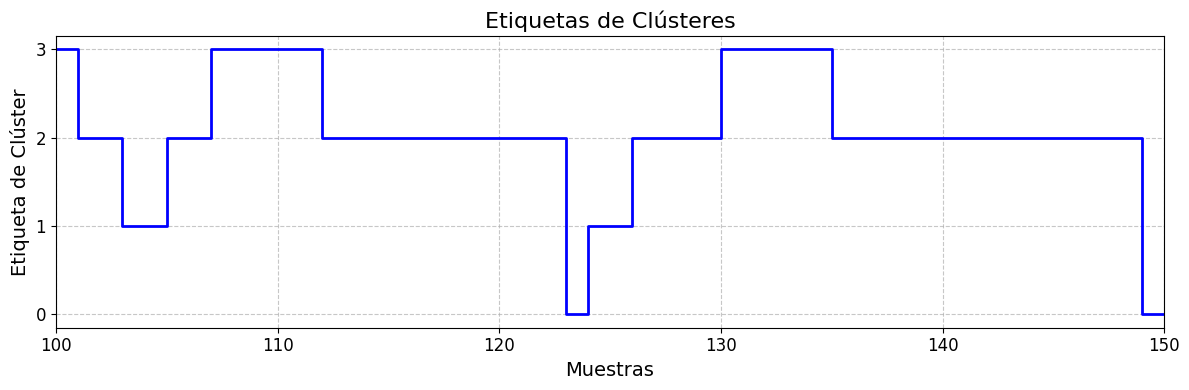

In [21]:
plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_cuant_eeg_simulado_joven.shape[1]), idx_cuantico_simulado_joven, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.xlim([100,150])
plt.tight_layout() 
plt.show()

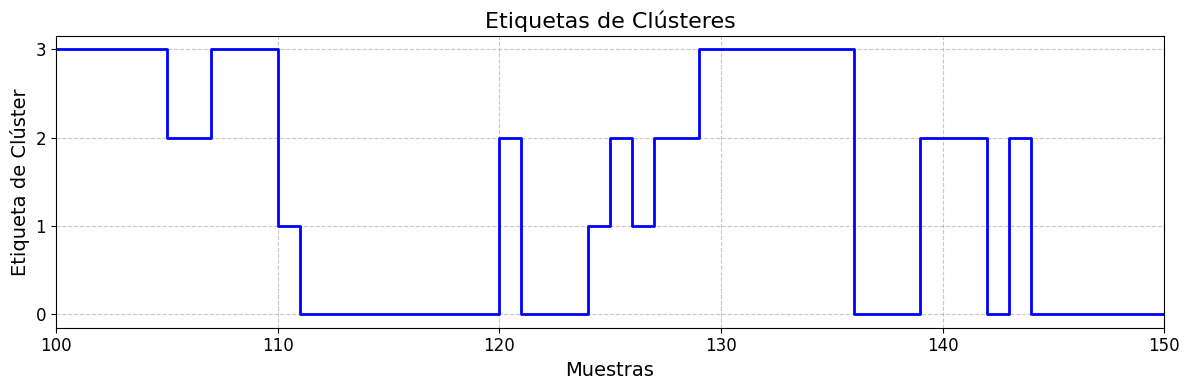

In [22]:
idx_cuantico_simulado_joven_gmm = clustering_gmm(input_sequence_cuant_eeg_simulado_joven)

plt.figure(figsize=(12, 4))  
plt.step(range(input_sequence_cuant_eeg_simulado_joven.shape[1]), idx_cuantico_simulado_joven_gmm, where='post', color='blue', linewidth=2) 
plt.title('Etiquetas de Clústeres', fontsize=16)
plt.xlabel('Muestras', fontsize=14)  
plt.ylabel('Etiqueta de Clúster', fontsize=14)  
plt.yticks(np.arange(num_clusters))  
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.7)  
plt.xlim([100,150])
plt.tight_layout() 
plt.show()

## Clasificador Random Forest Clásico.

In [23]:
def reservoir_computing_clasico(sujeto_synt, num_input_channels=10, num_reservoir_neurons=80):  
    """  
    Implementación de un reservorio clásico.  

    Args:  
    - sujeto_synt: array de forma (num_muestras, num_input_channels) con los datos de entrada.  
    - num_input_channels: Dimensionalidad de entrada (número de canales). Default es 10.  
    - num_reservoir_neurons: Número de neuronas en el reservorio. Default es 80.   

    Returns:  
    - input_sequence: Secuencia de entrada procesada.  
    """  
    num_training_samples = sujeto_synt.shape[0]  # Número de muestras de entrenamiento  

    # Generar pesos de entrada al reservorio  
    input2res = np.random.randn(num_reservoir_neurons, num_input_channels)  

    # Generar pesos recurrentes del reservorio  
    res2res = np.random.randn(num_reservoir_neurons, num_reservoir_neurons)  

    # Normalizar las columnas de los pesos recurrentes  
    res2res = res2res / np.linalg.norm(res2res, axis=0)  

    # Normalización espectral
    eigvals = np.linalg.eigvals(res2res)
    spectral_radius = np.max(np.abs(eigvals))
    desired_radius = 0.9

    # Escalar la matriz recurrente
    res2res = (res2res / spectral_radius) * desired_radius

    # Sesgo del reservorio  
    input_bias = np.random.rand(num_reservoir_neurons, 1)  

    # Estados iniciales del reservorio  
    reservoir_states = np.random.randn(num_reservoir_neurons, num_training_samples + 1)  

    # Dinámicas del reservorio  
    for i in range(num_training_samples):  
        reservoir_states[:, i + 1] = np.tanh(  
            (0.05 * input2res @ sujeto_synt[i, :]) +  
            (0.95 * res2res @ reservoir_states[:, i]) +  
            input_bias.flatten()  
        )  

    # Extracción de la envolvente superior usando la transformada de Hilbert  
    RS_clasico_joven_synt = reservoir_states - np.mean(reservoir_states, axis=1, keepdims=True)  
    analytic_signal = hilbert(RS_clasico_joven_synt)  
    amplitude_envelope_clasico_joven_synt = np.abs(analytic_signal)  

    # Eliminamos los primeros puntos para estabilizar el reservorio  
    stable_start = min(300, amplitude_envelope_clasico_joven_synt.shape[1])  
    input_sequence = amplitude_envelope_clasico_joven_synt[:, stable_start:-50]  

    return input_sequence 

### Clustering con GMM.

Haremos uso del algoritmo Gaussian Mixture Model (GMM) que es un tipo de soft clustering(probabilístico)

In [24]:
# RC y clustering en sujetos jóvenes y adultos simulados.
all_cluster_sequences_gmm = []
for i in range(40):
    sujeto_synt = eeg_synthetic[i,:,:]
    input_sequence = reservoir_computing_clasico(sujeto_synt)
    idx_clasico = clustering_gmm(input_sequence)
    all_cluster_sequences_gmm.append(idx_clasico)

len(all_cluster_sequences_gmm)

40

### Adición de más features al clasificador.

In [25]:
# Histogramas de proporción de cada cluster.

def get_histogram(sequence, n_clusters = 4):
    hist, _ = np.histogram(sequence, bins=np.arange(0, n_clusters+1))
    hist_normalized = hist / np.sum(hist)  # Normalizar para obtener proporciones
    
    return hist_normalized

# Número de pasos consecutivos medio que la señal permanece en cada estado.

def avg_duration_per_cluster(sequence, n_clusters = 4):
    from itertools import groupby
    durations = {i: [] for i in range(0, n_clusters)}
    for val, group in groupby(sequence):
        durations[val].append(len(list(group)))
    return [np.mean(durations[i]) if durations[i] else 0 for i in range(0, n_clusters)]

# Matriz de frecuencia con la que se pasa de un cluster a otro.

def transition_matrix_features(sequence, n_clusters = 4):
    mat = np.zeros((n_clusters, n_clusters))
    for i in range(len(sequence)-1):
        mat[sequence[i], sequence[i+1]] += 1
    mat /= np.sum(mat)  # normalizar
    return mat.flatten()

In [26]:
features = []
n_clusters = 4

for seq in all_cluster_sequences_gmm:
    hist = get_histogram(seq, n_clusters)
    durations = avg_duration_per_cluster(seq, n_clusters)
    transition_mat = transition_matrix_features(seq, n_clusters)

    features.append(np.concatenate([hist, durations, transition_mat]))

X = np.array(features)
print(X.shape)

(40, 24)


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Etiquetas: 0 para jóvenes, 1 para adultos
y = np.array([0]*20 + [1]*20)

# Separar en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar un clasificador
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluar
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.80      0.80      0.80         5

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12



## Clasificador Random Forest Cuántico.

In [28]:
# Definir parámetros principales
num_qubits = 5 # hacemos uso de 5 qubits
num_channels = 10  # Número de canales

# Dispositivo cuántico
dev = qml.device("default.qubit", wires=num_qubits)

def quantum_reservoir(reservoir_weights, connectivity):  
    """Quantum Reservoir con compuertas CNOT y rotaciones."""  
    for i in range(num_qubits):
        qml.RX(reservoir_weights[i, i], wires=i)

    if connectivity == 'ring':  
        for j in range(num_qubits - 1):  
            qml.CNOT(wires=[j, j+1])  
    
    elif connectivity == 'star':  
        central_qubit = 0
        for j in range(1, num_qubits):  
            qml.CNOT(wires=[central_qubit, j])  

    elif connectivity == 'random':  
        qubit_pairs = [(j, k) for j in range(num_qubits) for k in range(j + 1, num_qubits)]  
        random.shuffle(qubit_pairs)  
        for j, k in qubit_pairs[num_qubits // 2]:  
            qml.CNOT(wires=[j, k])  
    
    elif connectivity == 'full':  
        for j in range(num_qubits):  
            for k in range(j + 1, num_qubits):  
                qml.CNOT(wires=[j, k])  

@qml.qnode(dev)
def quantum_echo_state_network(input_data, prev_output, weights_in, weights_rc, reservoir_weights):
    """Quantum Echo State Network (QESN) con 5 qubits activos por canal."""
    for i in range(num_qubits):
        qml.RX(0.05 * weights_in[i,:] @ input_data[:] + 0.95 * weights_rc[i,i] * prev_output[i], wires=i)
    
    quantum_reservoir(reservoir_weights, connectivity='full')
    
    return qml.probs(wires=range(num_qubits)) 

In [29]:
def reservoir_computing_cuantico(sujeto_synt, num_qubits = 5, num_channels = 10):  
    # Inicialización de pesos 

    weights_in = np.random.uniform(-np.pi, np.pi, (num_qubits, num_channels))  
    weights_rc = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))  
    reservoir_weights = np.random.uniform(-np.pi, np.pi, (num_qubits, num_qubits))  

    # Normalización espectral de weights_rc
    eigvals = np.linalg.eigvals(weights_rc)
    spectral_radius = np.max(np.abs(eigvals))
    desired_radius = 0.9
    weights_rc = (weights_rc / spectral_radius) * desired_radius
    
    time_steps = sujeto_synt.shape[0]  
    shape_qubits = 32 
    
    # Array para almacenar las salidas  
    outputs = np.zeros((time_steps, shape_qubits))  
    prev_output = np.zeros((shape_qubits))  
    
    # Loop en el tiempo  
    for t in range(time_steps):  
        q_probs = quantum_echo_state_network(sujeto_synt[t,:], prev_output[:],   
                                             weights_in, weights_rc, reservoir_weights)  
        final_output = np.tanh(q_probs)  
        outputs[t, :] = final_output  
        prev_output[:] = final_output  # Actualización del estado  
    
    # Transponer y ajustar el array de salida  
    outputs_tr = outputs.T  
    # Restar la media por fila  
    outputs_adj = outputs_tr - np.mean(outputs_tr, axis=1, keepdims=True)  
    
    # Aplicar transformada de Hilbert para obtener la señal analítica  
    analytic_signal = hilbert(outputs_adj, axis=1)  
    amplitude_envelope = np.abs(analytic_signal)  
    
    return amplitude_envelope  

In [30]:
# RC cuántico y clustering en sujetos jóvenes y adultos simulados.
all_cluster_sequences_cuantico_gmm = []
for i in range(40):
    sujeto_synt = eeg_synthetic[i,:,:]
    input_sequence = reservoir_computing_cuantico(sujeto_synt)
    idx_cuantico = clustering_gmm(input_sequence)
    all_cluster_sequences_cuantico_gmm.append(idx_cuantico)

len(all_cluster_sequences_cuantico_gmm)

40

In [72]:
features2 = []

for seq in all_cluster_sequences_cuantico_gmm:
    hist = get_histogram(seq, n_clusters)
    durations = avg_duration_per_cluster(seq, n_clusters)
    transition_mat = transition_matrix_features(seq, n_clusters)

    features2.append(np.concatenate([hist, durations, transition_mat]))

X2 = np.array(features2)

In [74]:
# Etiquetas: 0 para jóvenes, 1 para adultos
y2 = np.array([0]*20 + [1]*20)

# Separar en train/test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42) #,stratify=y

# Entrenar un clasificador
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train2, y_train2)

# Evaluar
y_pred2 = clf.predict(X_test2)
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.80      0.80      0.80         5

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12

